In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
    

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap

import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
from collections import defaultdict
import matplotlib.pyplot as pl
import tqdm
from itertools import product


from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph
from flow import translator, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import GraphExplainer


cannot set multiprocessing to spawn,             use ParallelCreditFlow with caution


In [3]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape)
X_display.head()

(32561, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [4]:
# use validation set to choose # of trees
params = {
    "eta": 0.01,
    "max_depth": 4,
    'objective':'binary:logistic',
    "subsample": 0.9
}
model = xgboost.train(params, xgb_train, 3000, evals = [(xgb_test, "test")], verbose_eval=100)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-error:0.15507
[100]	test-error:0.15077
[200]	test-error:0.14571
[300]	test-error:0.14417
[400]	test-error:0.14325
[500]	test-error:0.13742
[600]	test-error:0.13558
[700]	test-error:0.13266
[800]	test-error:0.12943
[900]	test-error:0.12867
[1000]	test-error:0.12867
[1100]	test-error:0.12759
[1200]	test-error:0.12682
[1300]	test-error:0.12682
[1400]	test-error:0.12682
[1500]	test-error:0.12575
[1600]	test-error:0.12544
[1700]	test-error:0.12498
[1800]	test-error:0.12544
[1900]	test-error:0.12513
[2000]	test-error:0.12498
[2100]	test-error:0.12529
[2200]	test-error:0.12560
[2300]	test-error:0.12560
[2400]	test-error:0.12544
[2500]	test-error:0.12529
[2600]	test-error:0.12513
[2700]	test-error:0.12560
[2800]	test-error:0.12560
[2900]	test-error:0.12529
[2999]	test-error:0.12498


# Compare flat models

In [5]:
def build_graph(model, X, display_translator={}):
    '''
    build and return a graph (list of nodes), to be runnable in main
    model: xgboost model
    X: background distribution (n, d) dataframe object
    x: target samples to be explained (n2, d)
    names: the feature names of the d dimensional features
    display_translator: translate features values to readable format, see flow.py:translator
    '''
    # build the graph
    names = X.columns
    nodes = [Node(name) for name in names]
    nodes.append(Node('predicted income >50k', 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, args[i]) for i, name in enumerate(names))))),
                      nodes, is_target_node=True))
    
    graph = Graph(nodes, display_translator=display_translator)
    return graph
    
nsamples = 1000
graph = build_graph(model, X, translator(X.columns, X, X_display))
explainer = GraphExplainer(graph, X, nruns=100) 
cf = explainer.shap_values(X[:nsamples])

sampling: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [8]:
bg = shap.utils.sample(X, 100)
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), bg)
shap_values = explainer(X[:10]) #nsamples])

In [12]:
sample_ind = 3
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age               53.0
Workclass          4.0
Education-Num      7.0
Marital Status     2.0
Occupation         6.0
Relationship       4.0
Race               2.0
Sex                1.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           39.0
Name: 3, dtype: float64
target: [0.07765882]


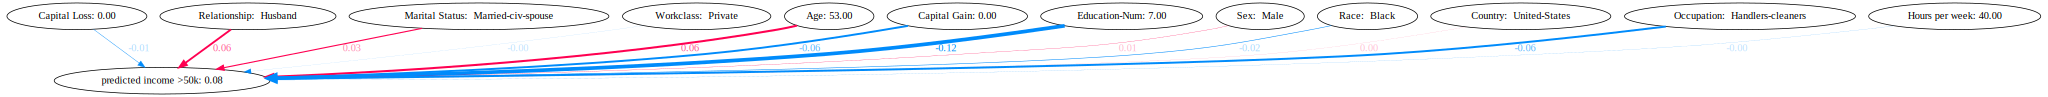

In [13]:
cf.draw(sample_ind)

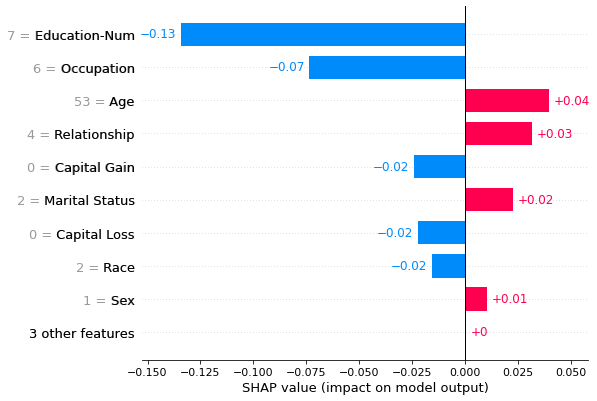

In [14]:
shap.plots.bar(shap_values[sample_ind])

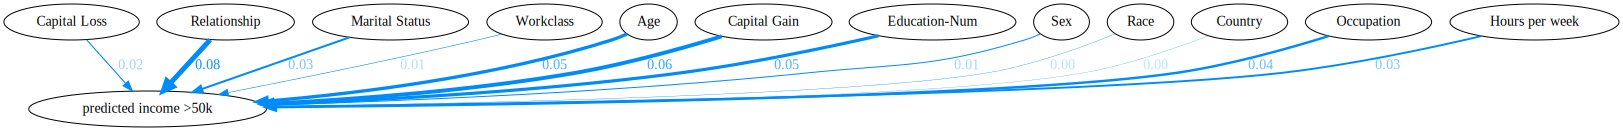

In [15]:
cf.draw(-1)

# Compare tree structures

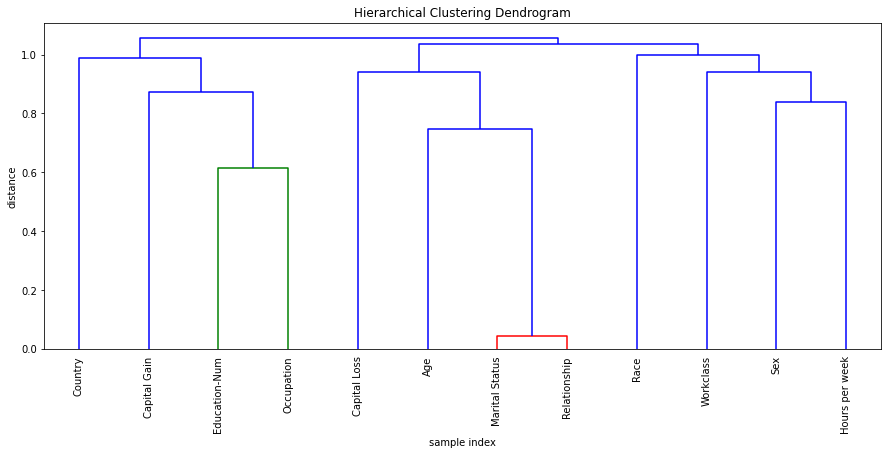

In [16]:
cluster_matrix = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

In [17]:
E = GraphExplainer(graph, X)
E.prepare_graph(X[:nsamples])
cf_h = CreditFlow(hcluster_graph(E.graph, list(X.columns), cluster_matrix), nruns=300)
cf_h.run()



sampling:   0%|          | 0/300 [00:00<?, ?it/s]

sampling:   0%|          | 1/300 [00:00<01:50,  2.70it/s]

sampling:   1%|          | 2/300 [00:00<01:50,  2.71it/s]

sampling:   1%|          | 3/300 [00:01<02:15,  2.19it/s]

sampling:   1%|▏         | 4/300 [00:02<03:02,  1.62it/s]

sampling:   2%|▏         | 5/300 [00:03<03:41,  1.33it/s]

sampling:   2%|▏         | 6/300 [00:04<04:09,  1.18it/s]

sampling:   2%|▏         | 7/300 [00:05<04:21,  1.12it/s]

sampling:   3%|▎         | 8/300 [00:06<04:32,  1.07it/s]

sampling:   3%|▎         | 9/300 [00:07<04:39,  1.04it/s]

sampling:   3%|▎         | 10/300 [00:08<05:09,  1.07s/it]

sampling:   4%|▎         | 11/300 [00:10<05:17,  1.10s/it]

sampling:   4%|▍         | 12/300 [00:11<05:04,  1.06s/it]

sampling:   4%|▍         | 13/300 [00:11<04:55,  1.03s/it]

sampling:   5%|▍         | 14/300 [00:12<04:48,  1.01s/it]

sampling:   5%|▌         | 15/300 [00:13<04:38,  1.02it/s]

sampling:   5%|▌         | 16/300 [00:14<04:42,  1.00it/

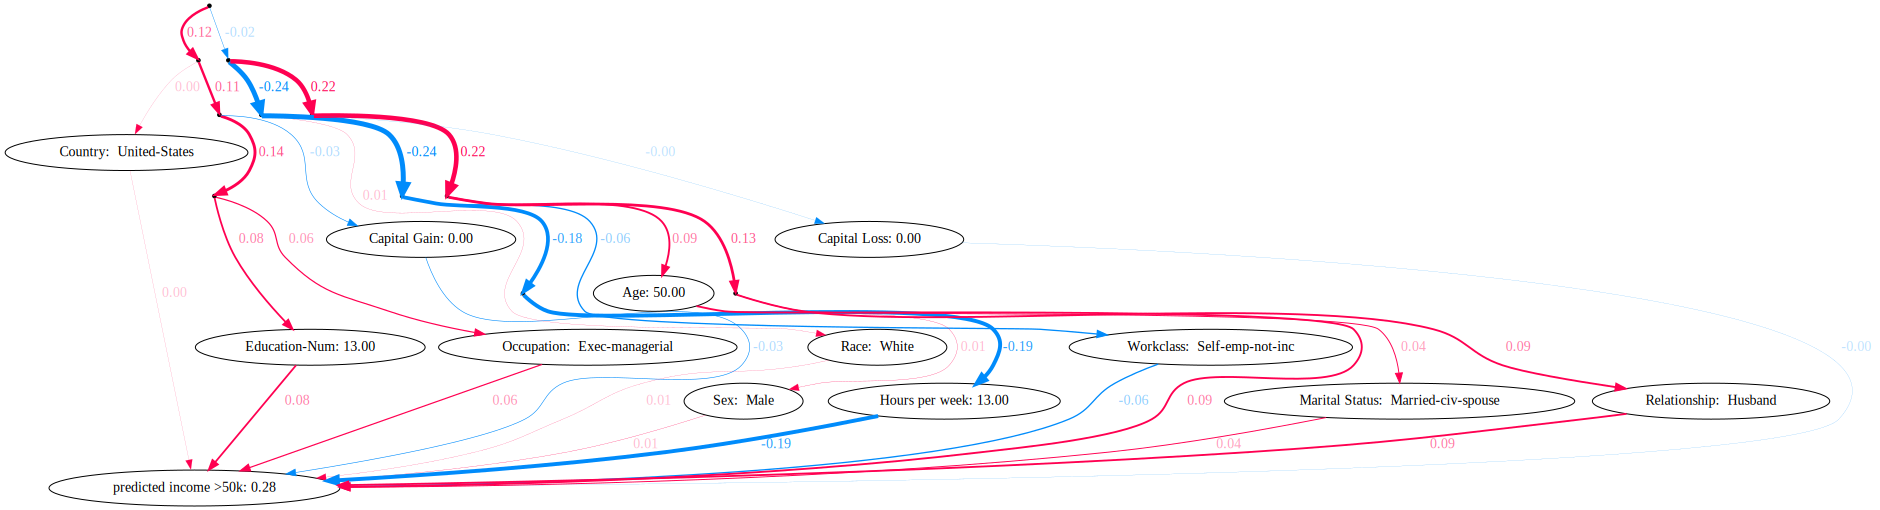

In [18]:
cf_h.draw(1, max_display=None)

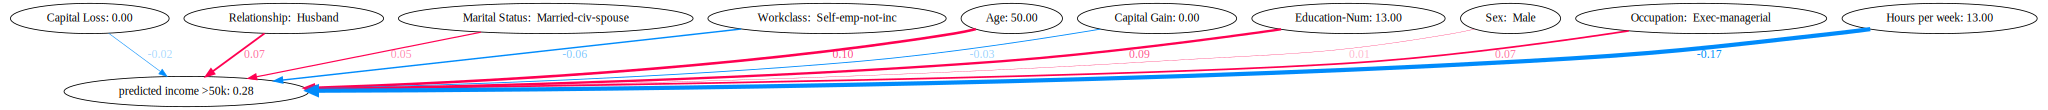

In [19]:
cf.draw(1, max_display=10)

In [20]:
bg = shap.utils.sample(X, 300)
masker = shap.maskers.TabularPartitions(bg)
masker.partition_tree = cluster_matrix
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), masker)
shap_values = explainer(X[:2])

Using 300 background data samples could cause slower run times. Consider shap.utils.sample(data, K) to summarize the background as K samples.


In [21]:
explainer

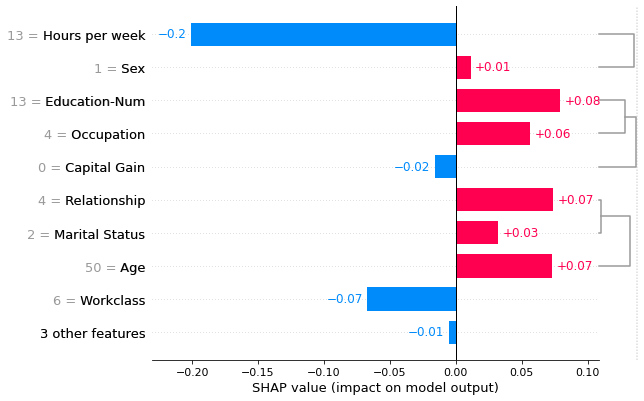

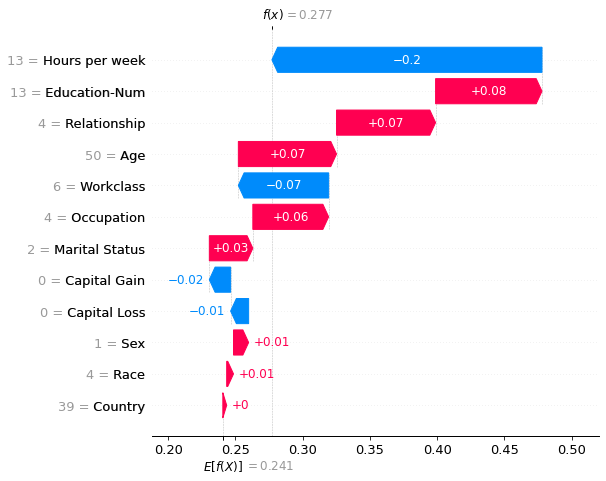

In [22]:
shap.plots.bar(shap_values[1], clustering=cluster_matrix, cluster_threshold=0.9)
i = 1
shap.plots.waterfall(shap_values[i], max_display=20)

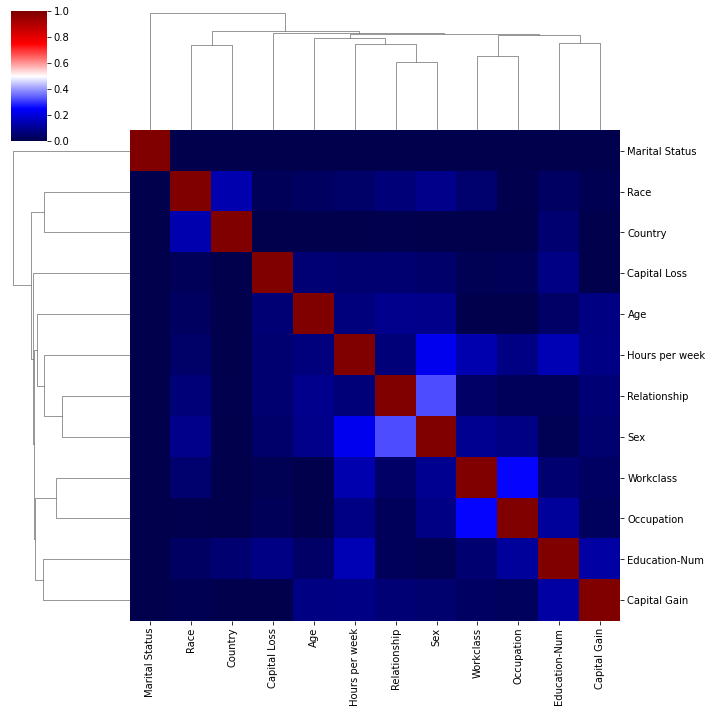

In [64]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

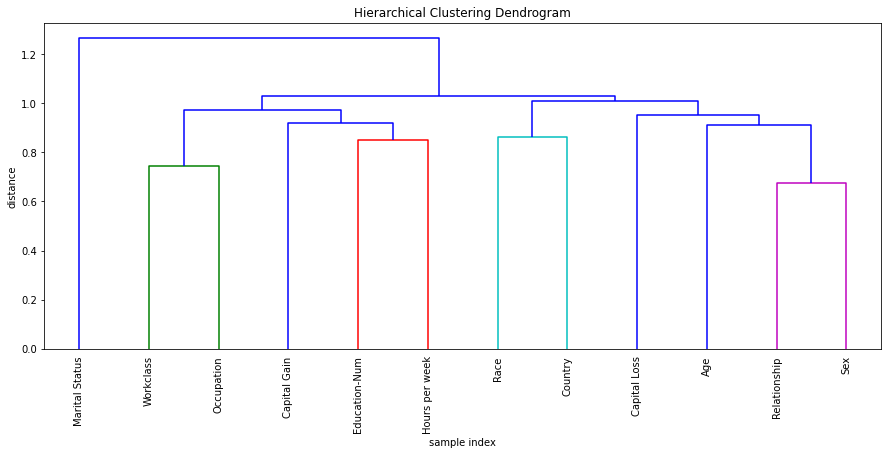

In [20]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

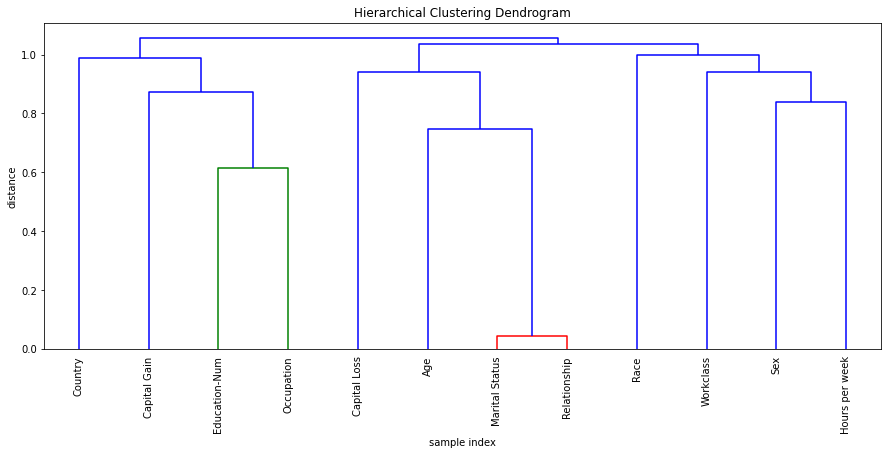

In [10]:
cluster_matrix = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

# Incorporate a causal understanding 

Following the ASV paper, we group features that are determined at birth from the rest of the features

Therefore, we have the following causal graph:

In [65]:
A = ['Age', 'Sex', 'Country', 'Race']
D = list(set(X.columns) - set(A))
A, D

(['Age', 'Sex', 'Country', 'Race'],
 ['Occupation',
  'Workclass',
  'Relationship',
  'Capital Gain',
  'Capital Loss',
  'Hours per week',
  'Education-Num',
  'Marital Status'])

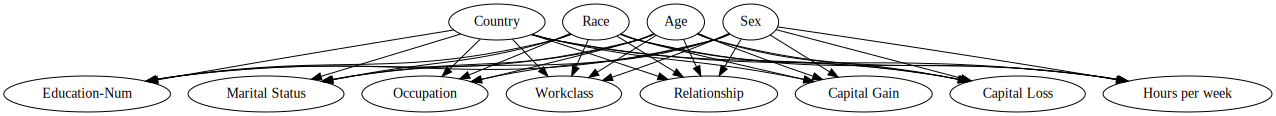

In [66]:
dot = Digraph()
idx = 0
idx_A = []
idx_D = []
for name in A:
    dot.node(f'{idx}', name)
    idx_A.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name)
    idx_D.append(idx)
    idx += 1

for a, d in product(idx_A, idx_D):
    dot.edge(str(a), str(d))
dot

While causal ordering requires that features should occur at specific order, the noise terms of the nodes have no reason to follow that. Theirfore a complete causal graph looks like this.

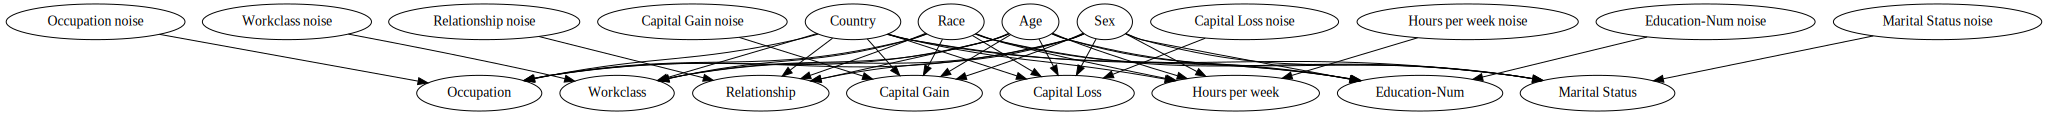

In [67]:
dot = Digraph()
idx = 0
idx_A = []
idx_D = []
idx_D_noise = []
for name in A:
    dot.node(f'{idx}', name)
    idx_A.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name)
    idx_D.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name + ' noise')
    idx_D_noise.append(idx)
    idx += 1

for a, d in product(idx_A, idx_D):
    dot.edge(str(a), str(d))
    
for d_n, d in zip(idx_D_noise, idx_D):
    dot.edge(str(d_n), str(d))
    
dot

In [68]:
def build_graph(model, X, display_translator={}):
    '''
    build and return a graph (list of nodes), to be runnable in main
    model: xgboost model
    X: background distribution (n, d) dataframe object
    x: target samples to be explained (n2, d)
    names: the feature names of the d dimensional features
    display_translator: translate features values to readable format, see flow.py:translator
    '''
    categorical_features = ['Workclass', 'Marital Status', 'Occupation',
                            'Relationship', 'Race', 'Sex', 'Country']
    
    def create_f(parents, m):
        def f_(*args):
            bs = len(args[0])
            o = m.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((n.name, args[i]) for i, n in enumerate(parents)))))
            if len(o) != bs: # discrete case
                o = o.reshape(bs, -1)
            return o
        return f_

    # build the graph
    names = list(X.columns)
    
    # note the ancestor and other nodes and sort according to names order
    A = ['Age', 'Sex', 'Country', 'Race']
    D = list(set(names) - set(A))
    A = sorted(A, key=lambda x: names.index(x))
    D = sorted(D, key=lambda x: names.index(x))
    
    nodes = []
    nodes_A = []
    nodes_D = []
    for name in A:
        node = Node(name)
        nodes.append(node)
        nodes_A.append(node)

    pbar = tqdm.tqdm(list(enumerate(D)))
    for i, name in pbar:
        pbar.set_description(f'learning dependency for {name}')
        parents = nodes_A
        
        # learn a new model here
        X_train, X_test, y_train, y_test = train_test_split(X[[p.name for p in parents]], np.array(X[name]), test_size=0.2, random_state=7)
        xgb_train = xgboost.DMatrix(X_train, label=y_train)
        xgb_test = xgboost.DMatrix(X_test, label=y_test)
        
        if name in categorical_features:
            
            num_class = len(np.unique(X[name]))
            params = {
                "eta": 0.002,
                "max_depth": 3,
                'objective': 'multi:softprob',
                'eval_metric': 'mlogloss',
                'num_class': num_class,
                "subsample": 0.5
            }
        else:
            params = {
                "eta": 0.002,
                "max_depth": 3,
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                "subsample": 0.5
            }
        m = xgboost.train(params, xgb_train, 500, evals = [(xgb_test, "test")], verbose_eval=100) #False)
            
        # use the new model:
        node = Node(name, 
                    create_f(parents, m), 
                    parents)
        nodes_D.append(node)
        nodes.append(node)
    
    parents = sorted(nodes_A + nodes_D, key=lambda x: names.index(x.name))
    nodes.append(Node('predicted income >50k', 
                      create_f(parents, model), 
                      parents, is_target_node=True))
    
    graph = Graph(nodes, display_translator=display_translator)
    return graph
    
nsamples = 1000
graph = build_graph(model, X, translator(X.columns, X, X_display))



  0%|          | 0/8 [00:00<?, ?it/s]

learning dependency for Workclass:   0%|          | 0/8 [00:00<?, ?it/s]

[0]	test-mlogloss:2.19314
[100]	test-mlogloss:1.88313
[200]	test-mlogloss:1.68807
[300]	test-mlogloss:1.55192
[400]	test-mlogloss:1.45190
[499]	test-mlogloss:1.37679




learning dependency for Workclass:  12%|█▎        | 1/8 [00:11<01:19, 11.40s/it]

learning dependency for Education-Num:  12%|█▎        | 1/8 [00:11<01:19, 11.40s/it]

[0]	test-rmse:9.87932
[100]	test-rmse:8.20241
[200]	test-rmse:6.85282
[300]	test-rmse:5.77531
[400]	test-rmse:4.92298
[499]	test-rmse:4.26283




learning dependency for Education-Num:  25%|██▌       | 2/8 [00:13<00:52,  8.69s/it]

learning dependency for Marital Status:  25%|██▌       | 2/8 [00:13<00:52,  8.69s/it]

[0]	test-mlogloss:1.94271
[100]	test-mlogloss:1.68994
[200]	test-mlogloss:1.51876
[300]	test-mlogloss:1.39377
[400]	test-mlogloss:1.29888
[499]	test-mlogloss:1.22575




learning dependency for Marital Status:  38%|███▊      | 3/8 [00:29<00:54, 10.82s/it]

learning dependency for Occupation:  38%|███▊      | 3/8 [00:29<00:54, 10.82s/it]    

[0]	test-mlogloss:2.70708
[100]	test-mlogloss:2.62392
[200]	test-mlogloss:2.56027
[300]	test-mlogloss:2.51008
[400]	test-mlogloss:2.46980
[499]	test-mlogloss:2.43720




learning dependency for Occupation:  50%|█████     | 4/8 [01:10<01:19, 19.90s/it]

learning dependency for Relationship:  50%|█████     | 4/8 [01:10<01:19, 19.90s/it]

[0]	test-mlogloss:1.78961
[100]	test-mlogloss:1.61357
[200]	test-mlogloss:1.48895
[300]	test-mlogloss:1.39597
[400]	test-mlogloss:1.32445
[499]	test-mlogloss:1.26879




learning dependency for Relationship:  62%|██████▎   | 5/8 [01:24<00:53, 17.94s/it]

learning dependency for Capital Gain:  62%|██████▎   | 5/8 [01:24<00:53, 17.94s/it]

[0]	test-rmse:7415.93311
[100]	test-rmse:7376.77930
[200]	test-rmse:7350.35889
[300]	test-rmse:7332.08057
[400]	test-rmse:7319.50195
[499]	test-rmse:7310.94922




learning dependency for Capital Gain:  75%|███████▌  | 6/8 [01:27<00:27, 13.67s/it]

learning dependency for Capital Loss:  75%|███████▌  | 6/8 [01:27<00:27, 13.67s/it]

[0]	test-rmse:410.60251
[100]	test-rmse:407.19025
[200]	test-rmse:404.91232
[300]	test-rmse:403.38498
[400]	test-rmse:402.36392
[499]	test-rmse:401.68558




learning dependency for Capital Loss:  88%|████████▊ | 7/8 [01:30<00:10, 10.43s/it]

learning dependency for Hours per week:  88%|████████▊ | 7/8 [01:30<00:10, 10.43s/it]

[0]	test-rmse:41.79467
[100]	test-rmse:34.81621
[200]	test-rmse:29.21365
[300]	test-rmse:24.75079
[400]	test-rmse:21.23435
[499]	test-rmse:18.52407




learning dependency for Hours per week: 100%|██████████| 8/8 [01:33<00:00, 11.64s/it]


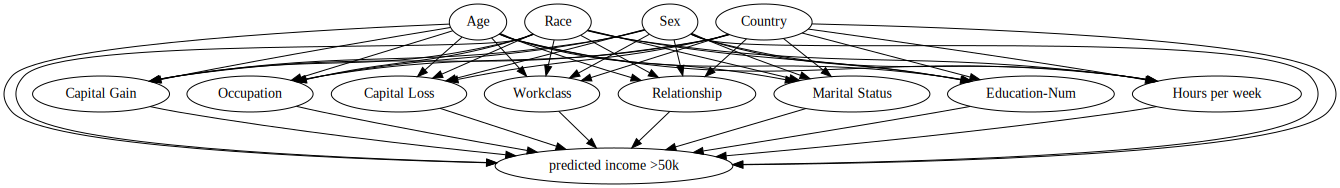

In [69]:
graph.draw()

In [70]:
cf_o = GraphExplainer(graph, X, nruns=30).shap_values(X[:nsamples]) 



sampling:   0%|          | 0/30 [00:00<?, ?it/s]

sampling:   3%|▎         | 1/30 [00:02<01:04,  2.22s/it]

sampling:   7%|▋         | 2/30 [00:04<01:02,  2.22s/it]

sampling:  10%|█         | 3/30 [00:06<01:00,  2.22s/it]

sampling:  13%|█▎        | 4/30 [00:09<01:00,  2.33s/it]

sampling:  17%|█▋        | 5/30 [00:12<01:07,  2.70s/it]

sampling:  20%|██        | 6/30 [00:16<01:11,  2.97s/it]

sampling:  23%|██▎       | 7/30 [00:19<01:12,  3.14s/it]

sampling:  27%|██▋       | 8/30 [00:23<01:11,  3.27s/it]

sampling:  30%|███       | 9/30 [00:27<01:12,  3.47s/it]

sampling:  33%|███▎      | 10/30 [00:31<01:09,  3.49s/it]

sampling:  37%|███▋      | 11/30 [00:34<01:07,  3.54s/it]

sampling:  40%|████      | 12/30 [00:38<01:03,  3.53s/it]

sampling:  43%|████▎     | 13/30 [00:41<01:01,  3.62s/it]

sampling:  47%|████▋     | 14/30 [00:45<00:59,  3.72s/it]

sampling:  50%|█████     | 15/30 [00:49<00:56,  3.74s/it]

sampling:  53%|█████▎    | 16/30 [00:53<00:52,  3.72s/it]

sampling:  57

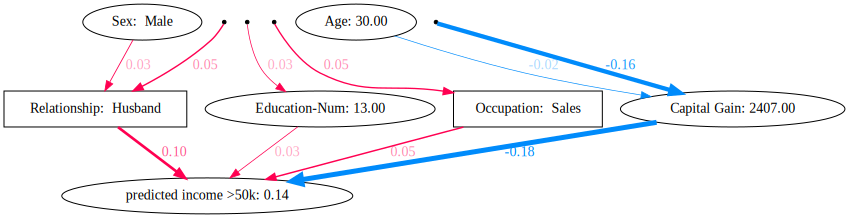

In [71]:
sample_ind = 60
cf_o.fold_noise = True
cf_o.draw(idx=sample_ind, max_display=10)

In [72]:
cf_f = GraphExplainer(flatten_graph(graph), X, nruns=30).shap_values(X[:nsamples])



sampling:   0%|          | 0/30 [00:00<?, ?it/s]

sampling:   3%|▎         | 1/30 [00:00<00:10,  2.75it/s]

sampling:   7%|▋         | 2/30 [00:00<00:09,  2.80it/s]

sampling:  10%|█         | 3/30 [00:01<00:09,  2.84it/s]

sampling:  13%|█▎        | 4/30 [00:01<00:09,  2.84it/s]

sampling:  17%|█▋        | 5/30 [00:01<00:08,  2.83it/s]

sampling:  20%|██        | 6/30 [00:02<00:08,  2.85it/s]

sampling:  23%|██▎       | 7/30 [00:02<00:07,  2.89it/s]

sampling:  27%|██▋       | 8/30 [00:02<00:07,  2.85it/s]

sampling:  30%|███       | 9/30 [00:03<00:07,  2.82it/s]

sampling:  33%|███▎      | 10/30 [00:03<00:07,  2.55it/s]

sampling:  37%|███▋      | 11/30 [00:03<00:07,  2.64it/s]

sampling:  40%|████      | 12/30 [00:04<00:06,  2.67it/s]

sampling:  43%|████▎     | 13/30 [00:04<00:06,  2.68it/s]

sampling:  47%|████▋     | 14/30 [00:05<00:05,  2.72it/s]

sampling:  50%|█████     | 15/30 [00:05<00:05,  2.77it/s]

sampling:  53%|█████▎    | 16/30 [00:05<00:05,  2.78it/s]

sampling:  57

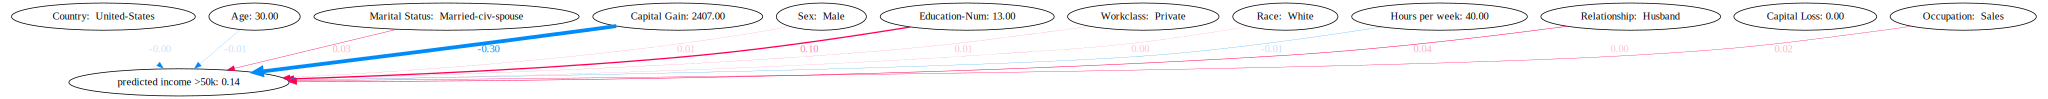

In [73]:
cf_f.draw(60)

# Comparison of views

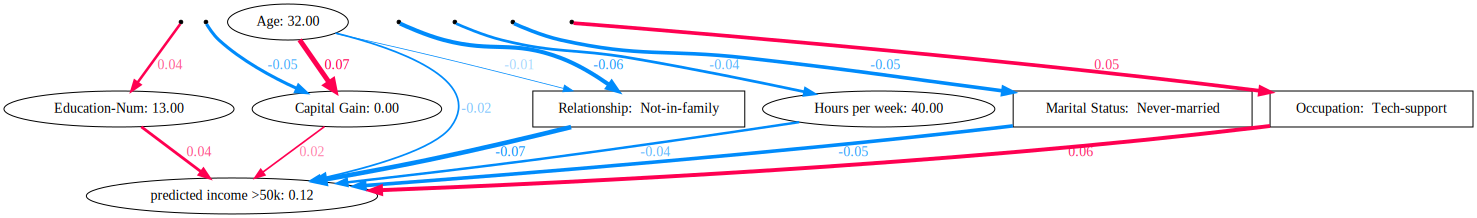

In [94]:
sample_ind = 600
cf_o.fold_noise = True
cf_o.draw(idx=sample_ind, max_display=15)

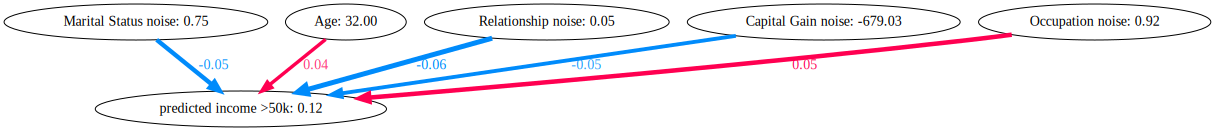

In [90]:
cf_o.fold_noise = False
cf_o.draw_asv(sample_ind, max_display=5)

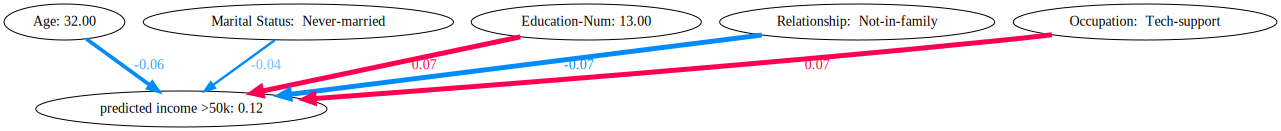

In [91]:
cf_f.draw(sample_ind, max_display=5)